In [187]:
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import minimize
from scipy.io import loadmat
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random

## Import Matlab generated data ("truth")

In [12]:
dyn = pd.read_csv('./debug_data/dyn_model_data.csv')

In [13]:
dyn

,0,0.1,0.2,5,0.3,0.4,0.5,0.6,0.7,0.8,0.15
0,0.005,0.000000e+00,0.000000e+00,5.0000,0.000000,0.000000,0,0.000150,0,0.00040,0.15000
1,0.010,0.000000e+00,0.000000e+00,5.0000,-0.000015,-0.000020,0,0.000300,0,0.00080,0.15000
2,0.015,-1.505900e-08,-1.964700e-08,5.0000,-0.000044,-0.000057,0,0.000450,0,0.00120,0.15000
3,0.020,-5.930000e-08,-7.705900e-08,5.0000,-0.000086,-0.000112,0,0.000600,0,0.00160,0.15000
4,0.025,-1.459800e-07,-1.889500e-07,5.0000,-0.000141,-0.000182,0,0.000750,0,0.00200,0.14999
...,...,...,...,...,...,...,...,...,...,...,...
4995,27.243,-1.843200e+00,-1.204600e-01,5.2816,0.058949,0.068220,0,-0.040159,0,-0.38402,-0.12651
4996,27.248,-1.843700e+00,-1.203900e-01,5.2812,0.059145,0.068443,0,-0.040285,0,-0.38391,-0.12635
4997,27.253,-1.844300e+00,-1.203200e-01,5.2809,0.059341,0.068667,0,-0.040411,0,-0.38380,-0.12619
4998,27.259,-1.844900e+00,-1.202600e-01,5.2805,0.059537,0.068890,0,-0.040538,0,-0.38368,-0.12602


In [28]:
kin = pd.read_csv('./debug_data/kin_model_data.csv', names=['x', 'y', 'psi', 'vx', 'vy', 'r', 'theta', 'steer', 'vtheta', 'D', 'delta'])

In [204]:
kin['delta_calc'] = (kin['steer'].shift(-1) - kin['steer']) / 1e-3
kin

,x,y,psi,vx,vy,r,theta,steer,vtheta,D,delta,delta_calc
0,0.000,0.000000e+00,0.000000e+00,5.0000,0.000000e+00,0.000000e+00,0,0.000000,0,0.00000,0.15000,0.15000
1,0.005,0.000000e+00,0.000000e+00,5.0000,0.000000e+00,0.000000e+00,0,0.000150,0,0.00040,0.15000,0.15000
2,0.010,-2.423400e-07,-2.524400e-07,5.0000,-1.938700e-11,-2.524400e-07,0,0.000300,0,0.00080,0.15000,0.15000
3,0.015,-7.282900e-07,-7.573200e-07,5.0000,-9.693700e-11,-7.573200e-07,0,0.000450,0,0.00120,0.15000,0.15000
4,0.020,-1.459100e-06,-1.514600e-06,5.0000,-2.714200e-10,-1.514600e-06,0,0.000600,0,0.00160,0.15000,0.14999
...,...,...,...,...,...,...,...,...,...,...,...,...
4996,27.261,-1.862300e+00,-1.199600e-01,5.2882,5.720200e-03,-1.199600e-01,0,-0.040159,0,-0.38402,-0.12651,-0.12600
4997,27.266,-1.862900e+00,-1.198900e-01,5.2878,5.715200e-03,-1.198900e-01,0,-0.040285,0,-0.38391,-0.12635,-0.12600
4998,27.271,-1.863400e+00,-1.198100e-01,5.2874,5.710200e-03,-1.198100e-01,0,-0.040411,0,-0.38380,-0.12619,-0.12700
4999,27.276,-1.864000e+00,-1.197400e-01,5.2871,5.705200e-03,-1.197400e-01,0,-0.040538,0,-0.38368,-0.12602,-0.12600


In [217]:
def tire_force(alpha, Fz, p):
    m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla = p
    return -alpha * cornering_stiff * (Fz / sample_fz)

def normal_force(vx, p):
    g = 9.8
    m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla = p # params of the car
    # traction due to aero
    F_lift = 0.5*rho*cla*(vx**2)
    FzF = -(lr * (m * g + F_lift)) / l;
    FzR = -(lf * (m * g + F_lift)) / l;
    
    return FzF, FzR

def dynamic_model(x, t, p):
    x, y, psi, vx, vy, r = x  # position
    D, steer = data['D'][int(t / 0.04)], data['steer'][int(t / 0.04)] # we will just take these based off the t input
    m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla = p # params of the car
    
    # estimate normal
    FzF, FzR = normal_force(vx, p)
    
    # compute slip angles
    alpha_f = math.atan((vy + r * lf) / vx) + steer
    alpha_r = math.atan((vy - r * lr) / vx)
    
    # compute tire forces
    F_yf = tire_force(alpha_f, FzF, p)
    F_yr = tire_force(alpha_r, FzR, p)
    
    # torque to force
    F_net = m * D
    
    # torque vectoring
    F_xf = lf / l * F_net
    F_xr = lr / l * F_net
    
    # accel
    ax = 1/m * (F_xr + F_xf * math.cos(steer) + F_yf * math.sin(steer)) + r * vy
    ay = 1/m * (F_yr - F_xf * math.sin(steer) + F_yf * math.cos(steer)) - r * vx
    a_yaw = 1/Iz * (-lf * F_xf * math.sin(steer) + lf * F_yf * math.cos(steer) - lr * F_yr)
    
    # bicycle model
    new_vx = vx * math.cos(psi) - vy * math.sin(psi)  # sin/cos(x), x should be radians.. not sure if our data is in deg/rad
    new_vy = vx * math.sin(psi) + vy * math.cos(psi)
    l # Note: R.Rajamani uses opposite steering coordinates
    return [new_vx, new_vy, r, ax, ay, a_yaw]
    
    
def kinematic_model(t, x, p):
    x, y, psi, vx, vy, r = x  # position
    D, steer = kin['D'][math.floor(t*1e3)], kin['steer'][math.floor(t*1e3)]
#     vtheta, D, delta = kin['vtheta'][int(t*1e3)], kin['D'][math.floor(t*1e3)], kin['delta_calc'][math.floor(t*1e3)] # TODO
#     vtheta, D, delta = u # inputs
    m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla = p # params of the car
#     vtheta
    beta = math.atan((math.tan(-steer) * lr)/l)
    ax = D * math.cos(beta)
    ay = D * math.sin(beta)
    
    dx = vx * math.cos(psi + beta)
    dy = vx * math.sin(psi + beta)
    dpsi = math.tan(-steer) * (vx * math.cos(beta)) / l # Note: R.Rajamani uses opposite steering coordinates
    
    dvx = ax
    dvy = ay
    dr = vx / lr * math.sin(beta)
    
    return np.array([dx, dy, dpsi, ax, ay, dr])


In [218]:
x0 = np.array([0, 0, 0, 5, 0, 0])
timespan = 5
num_pts = 1000*timespan + 1
tspan = np.linspace(0, timespan, num_pts)
p0 = (m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla) = (357, 2.971, 2.01, 0.960, 550.0, 125116, 4000, 1.225, -1.034)

In [219]:
sol = solve_ivp(kinematic_model, (0, 5.0), x0, t_eval=tspan, args=(p0,), rtol=1e-5, atol=1e-5)
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 86
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.000e+00, 1.000e-03, 2.000e-03, ..., 4.998e+00, 4.999e+00,
       5.000e+00])
 t_events: None
        y: array([[ 0.00000000e+00,  5.00000007e-03,  1.00000005e-02, ...,
         2.72708504e+01,  2.72761075e+01,  2.72813642e+01],
       [ 0.00000000e+00, -1.15322742e-07, -4.62612377e-07, ...,
        -1.86507306e+00, -1.86563644e+00, -1.86619918e+00],
       [ 0.00000000e+00, -1.19894602e-07, -4.80122445e-07, ...,
        -1.19877890e-01, -1.19805828e-01, -1.19733547e-01],
       [ 5.00000000e+00,  5.00000019e+00,  5.00000076e+00, ...,
         5.28734351e+00,  5.28695980e+00,  5.28657621e+00],
       [ 0.00000000e+00, -5.76459065e-13, -2.75682400e-11, ...,
         5.70675977e-03,  5.70173868e-03,  5.69670346e-03],
       [ 0.00000000e+00, -1.19894602e-07, -4.80122445e-07, ...,
        -1.19877890e-01, 

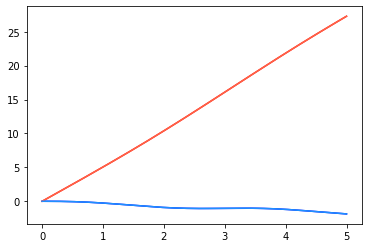

In [220]:
plt.plot(sol.t, sol.y[0,:], 'r', label='model output x')
plt.plot(sol.t, sol.y[1,:], 'b', label='model output y')
plt.plot(tspan, kin['x'], 'tomato', label='matlab output x')
plt.plot(tspan, kin['y'], 'dodgerblue', label='matlab output y')
plt.show()

In [222]:
((sol.y[0,:] - kin['x'])**2 + (sol.y[1,:] - kin['y'])**2).sum()

0.0037123843270594867

# Coding my own solver :')

In [173]:
# jk stackoverflow ftw!! modified from:
# https://stackoverflow.com/questions/54494770/how-to-set-fixed-step-size-with-scipy-integrate

def rk45_step(f,t,x,h,p):
    u = kin['vtheta'][int(t*1e3)], kin['D'][int(t*1e3)], kin['delta'][int(t*1e3)]
    k1 = f(t, x, u, p)
    k2 = f(t + 1./5*h, x + h*(1./5*k1), u, p)
    k3 = f(t + 3./10*h, x + h*(3./40*k1 + 9./40*k2), u, p)
    k4 = f(t + 4./5*h, x + h*(44./45*k1 - 56./15*k2 + 32./9*k3), u, p)
    k5 = f(t + 8./9*h, x + h*(19372./6561*k1 - 25360./2187*k2 + 64448./6561*k3 - 212./729*k4), u, p)
    k6 = f(t + h, x + h*(9017./3168*k1 - 355./33*k2 + 46732./5247*k3 + 49./176*k4 - 5103./18656*k5), u, p)

    v5 = 35./384*k1 + 500./1113*k3 + 125./192*k4 - 2187./6784*k5 + 11./84*k6
    k7 = f(t + h, x + h*v5, u, p)
    v4 = 5179./57600*k1 + 7571./16695*k3 + 393./640*k4 - 92097./339200*k5 + 187./2100*k6 + 1./40*k7;

    return v4,v5

def rk45_int(f, t, x0, p):
    N = len(t)
    x = np.empty((N,len(x0)))
    x[0] = x0
    for k in range(N-1):
        v4, v5 = rk45_step(f,t[k],x[k],t[k+1]-t[k],p)
        x[k+1] = (x[k] + (t[k+1]-t[k])*v5)
    return x

In [174]:
sol = rk45_int(kinematic_model, tspan, x0, p0)

In [175]:
len(sol[:,1])

5001

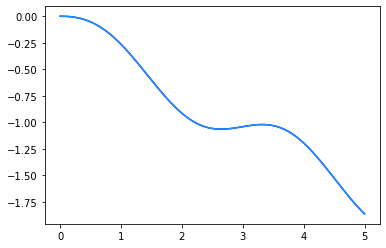

In [177]:
# plt.plot(tspan, sol.y[0,:], 'r', label='model output x')
plt.plot(tspan, sol[:,1], 'b', label='model output y')
# plt.plot(tspan, kin['x'], 'tomato', label='matlab output x')
plt.plot(tspan, kin['y'], 'dodgerblue', label='matlab output y')
plt.show()